In [115]:
#Import all modules needed for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
'''
The transaction data that I will be using for this project is stored in 2 separate CSV files. 
The first CSV file contains 1,296,675 credit card transactions from 2019-01-01 00:00:18 to 2020-06-21 12:13:37.
The second CSV file contains 555,719 new credit card transactions from 2020-06-21 12:14:25 to 2020-12-31 23:59:34.
First, I will read in both the CSV files into 2 separate Pandas DataFrames. Then, I will concatenate both the DataFrames
into a single Pandas DataFrame with 1,852,394 credit card transactions, which I will use for the next steps of this project.
'''
transaction_data_old = pd.read_csv("credit_card_transaction_data.csv")
transaction_data_new = pd.read_csv("credit_card_transaction_data_new.csv")

#Check to make sure that both CSV files were correctly read in
print(transaction_data_old.shape)
print(transaction_data_new.shape)

(1296675, 24)
(555719, 24)


In [5]:
#Concatenate into a single Pandas DataFrame by vertically stacking 1 DataFrame on top of another
transaction_data_updated = pd.concat([transaction_data_old, transaction_data_new])

#Check to make sure that the concatenation happened correctly
print(transaction_data_updated.shape)

(1852394, 24)


In [7]:
#Examine the data and see if we need to do any data cleaning
transaction_data_updated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud               i

In [9]:
transaction_data_updated.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.572438e+06
mean,5.371934e+05,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,4.683557e+04
std,3.669110e+05,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,2.582597e+04
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,1.001000e+03
25%,2.315490e+05,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,2.512400e+04
50%,4.630980e+05,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,4.587300e+04
75%,8.335758e+05,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,6.831300e+04
max,1.296674e+06,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00,9.940300e+04


In [11]:
#Check for missing values
transaction_data_updated.isnull().sum()

Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat                     0
merch_long                    0
is_fraud                      0
merch_zipcode            279956
dtype: int64

In [13]:
'''
It looks like all missing values are in the merch_zipcode column. We have a few options that we can consider to handle these missing values:

Option A: Drop rows with missing merch_zipcode. I don't think this is a good option as ~15% of rows have missing merch_zipcode values, and
dropping ~15% of our data might introduce bias into our future analyses, because what if there is a correlation between missing merch_zipcode
and fraudulent transactions?

Option B: Infer merch_zipcode from merch_lat and merch_long. I think this could be a viable option if we only had a handful of missing values.
But since we have almost 300,000 missing values, this will be a considerable effort, and due to the time constraints of this project, I don't
think this is a good option either.

Option C: Keep missing merch_zipcode values as is and use merch_lat and merch_long if we need location data for future analyses. If we can
determine that the missing merch_zipcode values are completely random, and there doesn't appear to be a correlation between missing
merch_zipcode and fraudulent transactions, we can use the merch_lat and merch_long columns instead, if we need location data.

Let's explore Option C further.
'''
#Add a missing_merch_zipcode flag column, which takes the value of 1 for missing merch_zipcode and the value of 0 otherwise
transaction_data_updated["missing_merch_zipcode"] = np.where(transaction_data_updated["merch_zipcode"].isnull(), 1, 0)

#Check to see if the flag was added correctly
transaction_data_updated.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,missing_merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN,1
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN,1
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0,0


In [15]:
'''
Use Pandas Groupby function to see the distribution of missing merch_zipcode values between fraudulent and non-fraudulent transactions.
In the is_fraud column, a value of 1 represents a fraudulent transaction and a value of 0 represents a non-fraudulent transaction.
'''
dist_missing_merch_zip = transaction_data_updated.groupby("is_fraud")["missing_merch_zipcode"].mean()
print(dist_missing_merch_zip)

is_fraud
0    0.151156
1    0.146617
Name: missing_merch_zipcode, dtype: float64


In [17]:
'''
From the above analysis, we see that 15.1% of non-fraudulent transactions have a missing merch_zipcode value, and 14.7% of fraudulent
transactions have a missing merch_zipcode value. Thus, it seems like the missing merch_zipcode values appear completely randomly between
fraudulent and non fraudulent transactions (~15% for each category). Thus, we can move forward with our approach to leave the missing
merch_zipcode values as is, and use the merch_lat and merch_long columns if we need location data for future analyses.

While exploring the data, I also noticed that there is an 'Unnamed: 0' column, which is simply the row id. We can drop this column to simplify
our dataset and to reduce the size of our dataset, which will make future work more efficient.

I will keep all other columns for now; I do not want to drop the merch_zipcode and missing_merch_zipcode columns, in case they are useful
in future analyses. I will store this data in the SQL database and I can then choose to leave out these columns when creating the view for ML.
'''
#Drop the 'Unnamed: 0' column
transaction_data_final = transaction_data_updated.drop("Unnamed: 0", axis = 1)

#Check to see if the column was dropped correctly
print(transaction_data_final.shape)
transaction_data_final.head()

(1852394, 24)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,missing_merch_zipcode
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0,0


In [19]:
'''
Now that the dataset is cleaned, we can do some Exploratory Data Analysis (EDA).

One thing that I'm immediately curious about is the distribution of fraudulent transactions in our dataset. From my research, I
understand that real-world credit card transaction data will likely be highly imbalanced because, on a day-to-day basis, there are
significantly more legitimate credit card transactions (negative/majority class) than fraudulent ones (positive/minority class).

It's important for me to check this assumption before doing any modeling because a positive class imbalance can cause
my model to become biased towards the majority/negative class. This will lead to poor performance of my model in detecting fraudulent
transactions (minority/positive class).

Let's validate this assumption.
'''
#Check the distribution of fraudulent transactions
total_num_transactions = transaction_data_final.shape[0]
num_non_fraud_transactions = (transaction_data_final["is_fraud"] == 0).sum()
num_fraud_transactions = (transaction_data_final["is_fraud"] == 1).sum()
print(f"Number(Percentage) of non-fraudulent transactions: {num_non_fraud_transactions}({(num_non_fraud_transactions / total_num_transactions) * 100:.2f}%)")
print(f"Number(Percentage) of fraudulent transactions: {num_fraud_transactions}({(num_fraud_transactions / total_num_transactions) * 100:.2f}%)")

Number(Percentage) of non-fraudulent transactions: 1842743(99.48%)
Number(Percentage) of fraudulent transactions: 9651(0.52%)


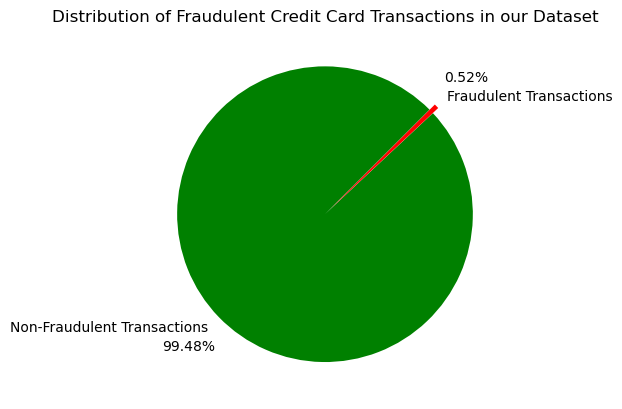

In [21]:
#Let's visualize this with a pie chart using Matplotlib
plt.pie([num_non_fraud_transactions, num_fraud_transactions], labels = ["Non-Fraudulent Transactions", "Fraudulent Transactions"], colors = ["green", "red"], autopct = "%1.2f%%", pctdistance = 1.28, startangle = 45, explode = (0, 0.05))
plt.title("Distribution of Fraudulent Credit Card Transactions in our Dataset")
plt.show()

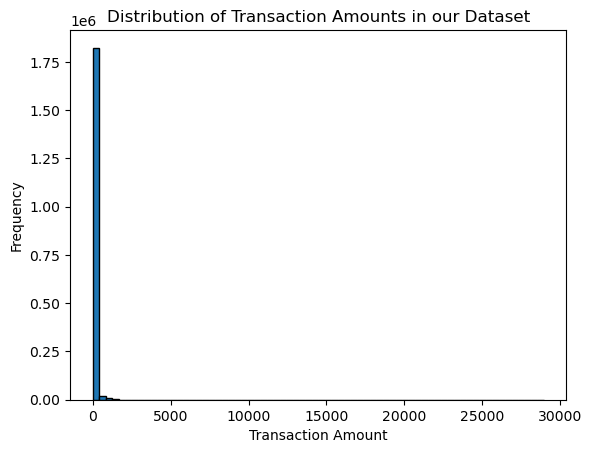

In [23]:
'''
From the above pie chart, I see that the dataset is indeed highly imbalanced; fraudulent transactions (positive class) make up only 0.52%
of our dataset, while non-fraudulent transactions (negative class) make up 99.48%.

Thus, when building my models, I need to use techniques, such as oversampling the minority class or undersampling the majority class.
Alternatively, I need to use algorithms that can handle class imbalanced datasets.

I'm also curious to explore the distribution of transaction amounts. From my research, I understand that fraudsters continually evolve their
fraud tactics to avoid being detected by fraud detection systems at banks and credit card companies. As a result, over time, fraudsters have
learnt to avoid performing single large-value transactions as these are easilly detected/flagged. Instead, fraudsters now make use of more
complicated fraud tactics, including making multiple smaller-value transactions.

Let's explore this assumption next.
'''
#Let's create a histogram to visualize the distribution of transaction amounts
plt.hist(transaction_data_final["amt"], bins = 70, edgecolor = "black")
plt.title("Distribution of Transaction Amounts in our Dataset")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

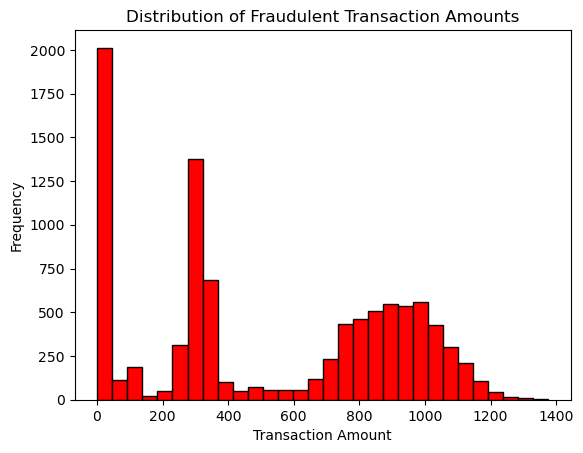

In [25]:
'''
From the above histogram, I see that the transaction amounts are heavily right-skewed, with most transactions being relatively small
ammounts, and a maximum transaction value of 28,948.90. This seems sensible, as, on a day-to-day basis, most credit card transactions are
likely to be smaller values. This analysis suggests that I need to do a transformation on the 'amt' column before doing further analyses.
I will keep the original 'amt' values for now, so as to preserve the original data in the forthcoming SQL database.

Furthermore, I see that there are some outliers. As per my research and my notes above, my hypothesis is that these outliers are likely
legitimate transactions for customers with higher income levels, as fraudsters are likely to make smaller-value transactions so as to try
to fly under the radar.

Let's explore this further.
'''
#Let's check the distribution of fraudulent transactions vs transaction amounts using a histogram
fraudulent_transactions = transaction_data_final[transaction_data_final["is_fraud"] == 1]
plt.hist(fraudulent_transactions["amt"], bins = 30, color = "red", edgecolor = "black")
plt.title("Distribution of Fraudulent Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

In [27]:
fraudulent_transactions["amt"].describe()

count    9651.000000
mean      530.661412
std       391.028873
min         1.060000
25%       240.075000
50%       390.000000
75%       902.365000
max      1376.040000
Name: amt, dtype: float64

In [29]:
non_fraudulent_transactions = transaction_data_final[transaction_data_final["is_fraud"] == 0]
non_fraudulent_transactions["amt"].describe()

count    1.842743e+06
mean     6.765128e+01
std      1.535481e+02
min      1.000000e+00
25%      9.610000e+00
50%      4.724000e+01
75%      8.256000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [31]:
'''
From the above analysis, I see that fraudulent transactions have a higher median transaction amount than non-fradulent transactions,
which suggests that fraudsters tend to target higher-value purchases, which makes sense. However, my analysis also shows that fraudsters do
not make single purchases of large amounts; the maximum non-fraudulent transaction amount is 28,948.90, while the maximum fraudulent
transaction amount is only 1376.04, which validates my hypothesis above.

The dataset contains 24 feature columns, and while I am curious to explore patterns in fraudulent transactions based on specific features,
such as merchant category, customer age, and transaction time, at the EDA stage, due to the time constraints of this project, I will skip
further EDA for now. Most feature columns will be used as inputs to the machine learning models, which will automatically detect patterns
associated with fraudulent transactions.
'''
transaction_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
 22  merch_zipcode          f

In [33]:
transaction_data_final.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,missing_merch_zipcode
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0,0


In [35]:
'''
As the next step of this project, I will create a Relational Database using SQLite, and store/organize the cleaned credit card transaction
data in this database in a normalized way, instead of keeping all the data (columns) in a single table.

While I acknowledge that the use of SQL is not required, and that this project could be done more efficiently using just Pandas, one of my
learning goals from this project is to improve my database design and SQL skills, and to get more comfortable with relational databases and
using SQL to query databases with millions of rows of data. I believe that this project extension will help make me a better Data Analyst/
Data Scientist, as in industry, we are rarely given a clean CSV file that has all the columns that we need for our analyses. Often, we need
to query a database to get the information that we need to do further analyses.

Additionally, while exploring this dataset, I noticed that there is a lot of sensitive customer information related to a customer's credit
card that is currently accessible to everyone that has access to this CSV file. As a future data owner in industry, one of my responsibilities
is to ensure that Personally Identifiable Information (PII) is shared with Authorized Users only. One way to achieve this is by using SQL to
create different views of the data. In other words, we can use SQL to create a copy of the data, containing only the information that the
person requesting the data is authorized to view.

Let's start by designing the database schema. Let's also save our cleaned dataset in a CSV file, in case we need to go back to it later.
'''
transaction_data_final.to_csv("credit_card_transaction_data_final.csv", index = False)

In [37]:
'''
While analyzing the data and feature columns, I think that we can use a snowflake schema for the database design, with 'TransactionDetails'
as a central fact table, and 'CustomerInformation' and 'MerchantInformation' as surrounding dimension tables, and 'CustomerAddressInformation'
as an additional dimension table for 'CustomerInformation'.

For the 'TransactionDetails' central fact table, we will have the following columns: trans_num (as the primary key), trans_date_trans_time,
cc_num (as a foreign key), merchant_id (as a foreign key), category, amt, unix_time, and is_fraud.

For this to work, we first need to check whether the 'trans_num' column has unique values, as a primary key must uniquely identify each row.
'''
#Check if trans_num is unique
num_unique_transactions = transaction_data_final["trans_num"].nunique()
if (num_unique_transactions == len(transaction_data_final)):
    print(f"The number of unique transactions is {num_unique_transactions}, which is equal to the number of rows in the DataFrame. Thus, trans_num is unique and can be used as a primary key for the 'TransactionDetails' central fact table.")
else:
    print("trans_num is not unique")

The number of unique transactions is 1852394, which is equal to the number of rows in the DataFrame. Thus, trans_num is unique and can be used as a primary key for the 'TransactionDetails' central fact table.


In [39]:
'''
For the 'CustomerInformation' surrounding dimension table, we will have the following columns: cc_num (as the primary key), first, last,
gender, job, and dob.

For the 'CustomerAddressInformation' additional dimension table, we will have the following columns: cc_num (as the primary key), street,
city, state, zip, lat, long, and city_pop.

For this to work, we first need to check whether the 'cc_num' column has unique values for each customer.
'''
#Check if cc_num is unique
#Group by unique credit card numbers, select the first, last, and dob columns, count the number of unique entries for first, last, and dob
#for each credit card number. Find the maximum value from all the unique counts (needs to be 1 for cc_num to be unique). For example,
#if a credit card number has 2 different first names, the count for first will be 2
unique_cc_num = (transaction_data_final.groupby("cc_num")[["first", "last", "dob"]].nunique().max()) == 1
if (unique_cc_num["first"]) & (unique_cc_num["last"]) & (unique_cc_num["dob"]):
    print("cc_num is unique and can be used as a primary key for the 'CustomerInformation' & 'CustomerAddressInformation' dimension tables.")
else:
    print("cc_num is not unique")

cc_num is unique and can be used as a primary key for the 'CustomerInformation' & 'CustomerAddressInformation' dimension tables.


In [41]:
'''
For the 'MerchantInformation' surrounding dimension table, we will have the following columns: merchant_id (as the primary key), merchant,
merch_lat, merch_long, merch_zipcode, and missing_merch_zipcode.

For this to work, we first need to create a merchant_id column and fill in a unique merchant_id for each merchant.

For the merchant_id column, we have a couple of options:

Option A: we can concatenate the 'merchant' and 'category' columns to create a unique string key for each merchant.

Option B: we can assign an integer value to each unique merchant and auto-increment this value for the next merchant.

Let's proceed with Option A, as it is the easiest to implement in the transaction_data_final DataFrame itself.
'''
#Create the new merchant_id column
transaction_data_final["merchant_id"] = (transaction_data_final["merchant"] + "_" + transaction_data_final["category"])
#Check to see if the column was created correctly
transaction_data_final.head()
print(f"There are {transaction_data_final["merchant_id"].nunique()} unique merchant id's. merchant_id can now be used as a primary key for the 'MerchantInformation' surrounding dimension table.")

There are 700 unique merchant id's. merchant_id can now be used as a primary key for the 'MerchantInformation' surrounding dimension table.


In [43]:
'''
Now that our database schema design is in place, we can create our database and start creating our fact and dimension tables, and then
insert our data into these tables.
'''
#Create the database
connection = sqlite3.connect("credit_card_transactions_database.sqlite")
cursor = connection.cursor()

In [47]:
#Create the tables in order so that a table exists before we create a foreign key mapping

#Create the 'CustomerInformation' dimension table first
cursor.execute('''
CREATE TABLE IF NOT EXISTS CustomerInformation (
    cc_num BIGINT PRIMARY KEY,
    first VARCHAR(30),
    last VARCHAR(30),
    gender VARCHAR(10),
    job VARCHAR(100),
    dob VARCHAR(10)
);
''')

#Create the 'CustomerAddressInformation' additional dimension table which depends on CustomerInformation
cursor.execute('''
CREATE TABLE IF NOT EXISTS CustomerAddressInformation (
    cc_num BIGINT PRIMARY KEY,
    street VARCHAR(100),
    city VARCHAR(100),
    state VARCHAR(100),
    zip INTEGER,
    lat DECIMAL,
    long DECIMAL,
    city_pop INTEGER,
    FOREIGN KEY (cc_num) REFERENCES CustomerInformation(cc_num) ON DELETE RESTRICT ON UPDATE CASCADE
);
''')

#Create the 'MerchantInformation' dimension table next
cursor.execute('''
CREATE TABLE IF NOT EXISTS MerchantInformation (
    merchant_id VARCHAR(150) PRIMARY KEY,
    merchant VARCHAR(100),
    merch_lat DECIMAL,
    merch_long DECIMAL,
    merch_zipcode REAL,
    missing_merch_zipcode TINYINT
);
''')

#Finally create the 'TransactionDetails' central fact table which depends on CustomerInformation and MerchantInformation
cursor.execute('''
CREATE TABLE IF NOT EXISTS TransactionDetails (
    trans_num VARCHAR(50) PRIMARY KEY,
    trans_date_trans_time TIMESTAMP,
    cc_num BIGINT,
    merchant_id VARCHAR(150),
    category VARCHAR(50),
    amt DECIMAL,
    unix_time BIGINT,
    is_fraud TINYINT,
    FOREIGN KEY (cc_num) REFERENCES CustomerInformation(cc_num) ON DELETE RESTRICT ON UPDATE CASCADE,
    FOREIGN KEY (merchant_id) REFERENCES MerchantInformation(merchant_id) ON DELETE RESTRICT ON UPDATE CASCADE
);
''')

connection.commit()

In [49]:
#Insert the data into the 'CustomerInformation' dimension table
#First create a Pandas DataFrame with unique customers
unique_customers = transaction_data_final.drop_duplicates(subset = ["cc_num"])
#Grab the required columns based on the schema design
customer_information = unique_customers[["cc_num", "first", "last", "gender", "job", "dob"]]
customer_information.to_sql("CustomerInformation", connection, if_exists = "append", index = False)

#Insert the data into the 'CustomerAddressInformation' additional dimension table
#Grab the required columns based on the schema design
customer_address_information = unique_customers[["cc_num", "street", "city", "state", "zip", "lat", "long", "city_pop"]]
customer_address_information.to_sql("CustomerAddressInformation", connection, if_exists = "append", index = False)

#Insert the data into the 'MerchantInformation' dimension table
#First create a Pandas DataFrame with unique merchant ids
unique_merchants = transaction_data_final.drop_duplicates(subset = ["merchant_id"])
#Grab the required columns based on the schema design
merchant_information = unique_merchants[["merchant_id", "merchant", "merch_lat", "merch_long", "merch_zipcode", "missing_merch_zipcode"]]
merchant_information.to_sql("MerchantInformation", connection, if_exists = "append", index = False)

#Insert the data into the 'TransactionDetails' fact table
#First create a Pandas DataFrame with unique transaction numbers
unique_transactions = transaction_data_final.drop_duplicates(subset = ["trans_num"])
#Grab the required columns based on the schema design
transaction_details = unique_transactions[["trans_num", "trans_date_trans_time", "cc_num", "merchant_id", "category", "amt", "unix_time", "is_fraud"]]
transaction_details.to_sql("TransactionDetails", connection, if_exists = "append", index = False)

1852394

In [51]:
#Check to make sure the data was inserted correctly in all tables
print(f"Number of rows in the CustomerInformation table: {cursor.execute("SELECT COUNT(*) FROM CustomerInformation;").fetchone()[0]}")
print(f"Number of rows in the CustomerAddressInformation table: {cursor.execute("SELECT COUNT(*) FROM CustomerAddressInformation;").fetchone()[0]}")
print(f"Number of rows in the MerchantInformation table: {cursor.execute("SELECT COUNT(*) FROM MerchantInformation;").fetchone()[0]}")
print(f"Number of rows in the TransactionDetails table: {cursor.execute("SELECT COUNT(*) FROM TransactionDetails;").fetchone()[0]}")

Number of rows in the CustomerInformation table: 999
Number of rows in the CustomerAddressInformation table: 999
Number of rows in the MerchantInformation table: 700
Number of rows in the TransactionDetails table: 1852394


In [53]:
#Save and close the database connection
connection.commit()
connection.close()

In [55]:
'''
Now that we have created our database and our fact and dimension tables, we can create a view of our data for the machine learning part
of this project.

For the ML view, I will select trans_num, trans_date_trans_time, cc_num, category, amt, and is_fraud from the 'TransactionDetails' table.

From the 'CustomerInformation' table, I will select gender, job, and dob.

From the 'CustomerAddressInformation' table, I will select city, state, zip, lat, long, and city_pop.

From the 'MerchantInformation' table, I will select merchant, merch_lat, merch_long, and missing_merch_zipcode.

I am excluding the following columns:
- unix_time from the 'TransactionDetails' table, as we already have 1 timestamp representation through the trans_date_trans_time column.
- first, last from the 'CustomerInformation' table, as these are personal identifiers and don't contain patterns for fraud detection.
- street from the 'CustomerAddressInformation' table, as this is also a personal identifier with no inherent fraud pattern.
- merchant_id, merch_zipcode from the 'MerchantInformation' table, as merchant_id is a key that we created specifically to normalize
our database, and merch_zipcode is redundant, given that it has missing values and we already have the merch_lat, merch_long, and
missing_merch_zipcode columns.
'''
connection = sqlite3.connect("credit_card_transactions_database.sqlite")
cursor = connection.cursor()

#Create the ML view based on the above rationale
cursor.execute('''
CREATE VIEW transaction_data_mlv AS
SELECT
    TransactionDetails.trans_num,
    TransactionDetails.trans_date_trans_time,
    TransactionDetails.cc_num,
    TransactionDetails.category,
    TransactionDetails.amt,
    TransactionDetails.is_fraud,
    CustomerInformation.gender,
    CustomerInformation.job,
    CustomerInformation.dob,
    CustomerAddressInformation.city,
    CustomerAddressInformation.state,
    CustomerAddressInformation.zip,
    CustomerAddressInformation.lat,
    CustomerAddressInformation.long,
    CustomerAddressInformation.city_pop,
    MerchantInformation.merchant,
    MerchantInformation.merch_lat,
    MerchantInformation.merch_long,
    MerchantInformation.missing_merch_zipcode
FROM TransactionDetails
LEFT JOIN CustomerInformation ON TransactionDetails.cc_num = CustomerInformation.cc_num
LEFT JOIN CustomerAddressInformation ON CustomerInformation.cc_num = CustomerAddressInformation.cc_num
LEFT JOIN MerchantInformation ON TransactionDetails.merchant_id = MerchantInformation.merchant_id;
''')

connection.commit()

In [57]:
#Load the view as a Pandas DataFrame
transaction_data_ml = pd.read_sql("SELECT * FROM transaction_data_mlv;", connection)

#Check if the view was loaded in correctly
transaction_data_ml.head()

,trans_num,trans_date_trans_time,cc_num,category,amt,is_fraud,gender,job,dob,city,state,zip,lat,long,city_pop,merchant,merch_lat,merch_long,missing_merch_zipcode
0,0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,0,F,"Psychologist, counselling",1988-03-09,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"fraud_Rippin, Kub and Mann",36.011293,-82.048315,0
1,1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,0,F,Special educational needs teacher,1978-06-21,Orient,WA,99160,48.8878,-118.2105,149,"fraud_Heller, Gutmann and Zieme",49.159047,-118.186462,1
2,a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,entertainment,220.11,0,M,Nature conservation officer,1962-01-19,Malad City,ID,83252,42.1808,-112.2620,4154,fraud_Lind-Buckridge,43.150704,-112.154481,0
3,6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,0,M,Patent attorney,1967-01-12,Boulder,MT,59632,46.2306,-112.1138,1939,"fraud_Kutch, Hermiston and Farrell",47.034331,-112.561071,1
4,a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,0,M,Dance movement psychotherapist,1986-03-28,Doe Hill,VA,24433,38.4207,-79.4629,99,fraud_Keeling-Crist,38.674999,-78.632459,0


In [59]:
transaction_data_ml.shape

(1852394, 19)

In [61]:
#Close the database connection
connection.close()

In [89]:
'''
Before I start modeling, I need to do some feature engineering to preprocess the data for machine learning. The dataset contains a mix of
categorical variables and numerical variables. I need to encode(convert into a numerical format) categorical variables because most
machine learning algorithms cannot process text, and are designed to work with numbers only. Additionally, I need to standardize
numerical variables because machine learning algorithms struggle when features all have different scales. Standardization brings all
features to a common scale, so all features contribute equally, which allows the model to focus on patterns in data, instead of the scale.

Specifically, here's what I plan to do for each column:

- trans_num: I will save and drop this column for the prediction stage, as it is a a unique identifier for each transaction with no predictive
value. After prediction, I can map it back, if needed, to help with identification.
- trans_date_trans_time: Categorical variable; I will extract hour, month, and day as separate feature columns, standardize them,
and then drop this column.
- cc_num: I will save and drop this column for the prediction stage, as it is a unique identifier for each customer with no predictive
value. After prediction, I can map it back, if needed, to help with identification.
- category: Categorical variable; will encode using one-hot encoding, as there are 14 unique values.
- amt: We saw earlier that it is heavily right-skewed; I will do a log transformation of the amt column and then standardize.
- gender: Categorical variable; will encode using one-hot encoding, as there are 2 unique values.
- job: Categorical variable; will encode using label encoding, as there are 497 unique values, and then standardize.
- dob: Categorical variable; I will convert this column into an 'age' numerical column and then standardize.
- city: I will drop this column as I can use lat and long to get location information for any distance calculations.
- state: I will keep this column as 2 cities next to each other, but in different states, may have different fraud patterns. Categorical
variable; will encode using one-hot encoding, as there are 51 unique values.
- zip: I will drop this column as I can use lat and long to get location information for any distance calculations.
- lat: Will keep as is and standardize.
- long: Will keep as is and standardize.
- city_pop: Will keep as is and standardize.
- merchant: Categorical variable; will encode using label encoding, as there are 693 unique values, and then standardize.
- merch_lat: Will keep as is and standardize.
- merch_long: Will keep as is and standardize.
- missing_merch_zipcode: I will drop this column as I can use merch_lat and merch_long for any distance calculations, and these 2 columns
do not have any missing values.

For high-cardinality features, like job and merchant, I will use label encoding rather than one-hot encoding to avoid the curse of
dimensionality; will need to choose appropriate machine learning models that can handle this.

Since, for this project, we are only interested in understanding how good our machine learning models are at predicting fraud, we do not need
to do a correlation analysis to identify, and remove, highly correlated features.
'''
#Save 'trans_num' and 'cc_num' before dropping so that they can be mapped back later
trans_num_save = transaction_data_ml["trans_num"].copy()
cc_num_save = transaction_data_ml["cc_num"].copy()

#Drop 'trans_num', 'cc_num', 'city', 'zip', 'missing_merch_zipcode'
transaction_data_ml_cleaned = transaction_data_ml.copy()
transaction_data_ml_cleaned = transaction_data_ml_cleaned.drop(["trans_num", "cc_num", "city", "zip", "missing_merch_zipcode"], axis = 1)

#Extract hour, month, and day as separate feature columns from 'trans_date_trans_time', and drop 'trans_date_trans_time'
transaction_data_ml_cleaned["trans_date_trans_time"] = pd.to_datetime(transaction_data_ml_cleaned["trans_date_trans_time"])
transaction_data_ml_cleaned["hour"] = transaction_data_ml_cleaned["trans_date_trans_time"].dt.hour
transaction_data_ml_cleaned["month"] = transaction_data_ml_cleaned["trans_date_trans_time"].dt.month
transaction_data_ml_cleaned["day"] = transaction_data_ml_cleaned["trans_date_trans_time"].dt.day
transaction_data_ml_cleaned = transaction_data_ml_cleaned.drop("trans_date_trans_time", axis = 1)

#Convert 'dob' to 'age', and drop 'dob'
transaction_data_ml_cleaned["dob"] = pd.to_datetime(transaction_data_ml_cleaned["dob"])
current_date = pd.Timestamp("2020-12-31") #The dataset contains transactions from 2019-2020, so freezing customer age as of 2020-12-31
transaction_data_ml_cleaned["age"] = ((current_date - transaction_data_ml_cleaned["dob"]).dt.days // 365)
transaction_data_ml_cleaned = transaction_data_ml_cleaned.drop("dob", axis = 1)

#Log transform 'amt'
transaction_data_ml_cleaned["amt_log"] = np.log(transaction_data_ml_cleaned["amt"])
transaction_data_ml_cleaned = transaction_data_ml_cleaned.drop("amt", axis = 1)

#Use one-hot encoding to encode 'category', 'gender', and 'state'
transaction_data_ml_cleaned = pd.get_dummies(transaction_data_ml_cleaned, columns = ["category", "gender", "state"], drop_first = True)

#Use label encoding to encode 'job' and 'merchant'
label_encoded_job = LabelEncoder()
label_encoded_merchant = LabelEncoder()
transaction_data_ml_cleaned["job_encoded"] = label_encoded_job.fit_transform(transaction_data_ml_cleaned["job"])
transaction_data_ml_cleaned["merchant_encoded"] = label_encoded_merchant.fit_transform(transaction_data_ml_cleaned["merchant"])
transaction_data_ml_cleaned = transaction_data_ml_cleaned.drop(["job", "merchant"], axis = 1)

#Standardize numerical feature columns
numerical_columns = ["amt_log", "lat", "long", "city_pop", "merch_lat", "merch_long", "age", "hour", "month", "day", "job_encoded", "merchant_encoded"]
scaler = StandardScaler()
transaction_data_ml_cleaned[numerical_columns] = scaler.fit_transform(transaction_data_ml_cleaned[numerical_columns])

In [91]:
#Check to make sure that the preprocessing steps were carried out succesfully
transaction_data_ml_cleaned.head()

,is_fraud,lat,long,city_pop,merch_lat,merch_long,hour,month,day,age,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,job_encoded,merchant_encoded
0,0,-0.485167,0.658263,-0.282429,-0.497214,0.627876,-1.878901,-1.796249,-1.67309,-0.847549,...,False,False,False,False,False,False,False,False,0.848517,0.850891
1,0,2.040531,-2.035415,-0.293527,2.144035,-1.843657,-1.878901,-1.796249,-1.67309,-0.272946,...,False,False,False,False,True,False,False,False,1.266748,-0.506968
2,0,0.718034,-1.602731,-0.280243,0.937020,-1.431122,-1.878901,-1.796249,-1.67309,0.646419,...,False,False,False,False,False,False,False,False,0.394843,0.234134
3,0,1.516580,-1.591951,-0.287590,1.717201,-1.458929,-1.878901,-1.796249,-1.67309,0.416578,...,False,False,False,False,False,False,False,False,0.550794,0.084919
4,0,-0.023388,0.783024,-0.293693,0.037897,0.861491,-1.878901,-1.796249,-1.67309,-0.732628,...,False,False,True,False,False,False,False,False,-0.966178,-0.228433


In [93]:
transaction_data_ml_cleaned.shape

(1852394, 77)

In [95]:
'''
Due to the time and resource constraints of this project, I was unable to do extensive feature engineering. If I had more time, I would
have liked to explore adding the following features:

- Distance between customer and merchant.
- Time between transactions.
- Also, I have personally experienced fraud where the fraudsters make a couple of small-value transactions first, followed by a large-value
purchase, so this could be something interesting to think about for future work.

Now that I've completed the feature engineering and data preprocessing steps, I will start on the machine learning modeling part of this
project.
'''
#Start by separating out our response/target variable and our predictors/features
X = transaction_data_ml_cleaned.drop("is_fraud", axis = 1)
Y = transaction_data_ml_cleaned["is_fraud"]

#Check to make sure that this worked
print(f"The shape of our predictors/features set is: {X.shape}")
print(f"The shape of our response/target set is: {Y.shape}")

The shape of our predictors/features set is: (1852394, 76)
The shape of our response/target set is: (1852394,)


In [97]:
'''
First, I need to split the data into a training set and a testing set. Usually when doing statistical modeling, I would split the data into
a training set, a validation set, and a testing set. I would use the training set to train my model and I would use the validation set to
iteratively test my model, while modifying/tuning the parameters of the model. Finally, only once I'm satisfied with my model, and don't
intend to make any further refinements, would I test using the testing set, so as not to introduce bias.

Due to the time and resource constraints of this project, I will not be tuning any parameters for these models, and thus, I will use a
simple train-test split, rather than a train-validation-test split. If I had more time, I would certainly explore tuning the
parameters to improve the performance of each model.

Additionally, I am using an 80/20 train-test split, with stratification, rather than k-fold cross validation, since the dataset has 1.8M+
rows, and k-fold cross validation would be time intensive and computationally expensive; k-fold cross validation would be better for smaller
datasets.

During the EDA process, I observed that the dataset was highly imbalanced, with fraudulent transactions (minority/positive class) making up
only 0.52% of the dataset. I am using stratified sampling to handle this class imbalance; stratified sampling will ensure that both the
training set and the testing set maintain the same 0.52% fraud rate, which will prevent bias towards the majority/negative class.
'''
#Create an 80-20 train-test split with stratification
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 2912)

In [99]:
#Check to make sure the split happened correctly
print(f"Training set: {X_train.shape}, Fraud rate: {Y_train.mean():.4f}")
print(f"Testing set: {X_test.shape}, Fraud rate: {Y_test.mean():.4f}")

Training set: (1481915, 76), Fraud rate: 0.0052
Testing set: (370479, 76), Fraud rate: 0.0052


In [101]:
'''
Next, I need to identify, and use, appropriate machine learning algorithms to solve the problem of anomaly/fraud detection.

Our original dataset contains an 'is_fraud' column, which labels each transaction as being either fraudulent(1) or non-fraudulent(0). Since
our dataset is labelled, I can use supervised machine learning algorithms and I can train my algorithms using this labeled data.

I conducted a literature review of best-in-class algorithms for credit card fraud/anomaly detection. Through my research, I learned that
Logistic Regression is a commonly used algorithm. I will first implement the Logistic Regression algorithm as a simple baseline model
because I am solving a classification problem with a binary response/target variable (is_fraud).

I will also implement a more intricate supervised learning algorithm. Through my research, I learned that Random Forest is an
industry-standard supervised learning method. So next, I will implement the Random Forest algorithm since I have a high dimension dataset
(with 76 feature columns), and precision is particularly important for the credit card fraud/anomaly detection problem that I am trying
to solve.

However, in the real-world, it is often unrealistic to have a labelled dataset because it is expensive and time consuming to label data. So,
I will also use an unsupervised machine learning algorithm, where I will train my algorithm without the 'is_fraud' label. This will help
prepare me for industry scenarios where I don't have labels. Through my research, I learned that Isolation Forest is an industry-standard
unsupervised learning method. So finally, I will implement the Isolation Forest algorithm.

While there are certainly other good supervised learning algorithms, particularly XGBoost, I chose the Random Forest algorithm because it
trains faster than XGBoost, which is important given the time constraints of this project. Similarly, I chose the Isolation Forest
algorithm over other good unsupervised learning algorithms, particularly Local Outlier Factor, because Isolation Forest has an O(nlogn)
time complexity vs O(n²) for Local Outlier Factor, which makes Isolation Forest more efficient for our dataset with 1.8M+ transactions.

To address the class imbalance of this dataset, I will use the following strategies:

- For Logistic Regression and Random Forest, I will use the class_weight = 'balanced' parameter, which automatically adjusts for imbalance by
penalizing misclassifications of the minority class more heavily. This will ensure that the models handle the class imbalance internally,
and thus, I do not need to do the extra undersampling/oversampling preprocessing steps.

- For Isolation Forest, I will set the contamination parameter to 0.0052 to match the observed fraud rate of 0.52%.
'''
print("Model Training Started...")

#Logistic Regression (baseline supervised learning model)
logistic_regression_model = LogisticRegression(class_weight = "balanced", max_iter = 1000, random_state = 2912)
logistic_regression_model.fit(X_train, Y_train)
Y_pred_logistic_regression = logistic_regression_model.predict(X_test)

#Random Forest (advanced supervised learning model)
random_forest_model = RandomForestClassifier(class_weight = "balanced", n_estimators = 200, random_state = 2912)
random_forest_model.fit(X_train, Y_train)
Y_pred_random_forest = random_forest_model.predict(X_test)

#Isolation Forest (unsupervised learning model)
isolation_forest_model = IsolationForest(contamination = 0.0052, random_state = 2912)
isolation_forest_model.fit(X_train)
Y_pred_isolation_forest = isolation_forest_model.predict(X_test)
#Convert -1 for anomaly/fraud to 1 and convert 1 for normal to 0
Y_pred_isolation_forest = np.where(Y_pred_isolation_forest == -1, 1, 0)

print("Model Training Complete!")

Model Training Started...
Model Training Complete!


In [125]:
'''
Now that I have trained all 3 models, and used the models to predict fraudulent transactions in the testing set, I need to evaluate the
performance of the 3 models.

I conducted a literature review of best-in-class methods for evaluating model performance on class imbalanced datasets. Through  my research,
I learned that relying on model accuracy would be misleading with imbalanced data. As a result, I will evaluate each model using Precision,
Recall, and F1-score, which will provide a more complete picture of model performance.

Additionally, for this problem, banks and credit card companies are especially concerned with the number of False Negatives. A False Negative
is a case where the model flags a fraudulent transaction as being non-fraudulent. This is especially dangerous for banks and credit card 
companies; a high percentage of False Negatives means that the model is letting fraudulent transactions go undetected, which is incredibly
dangerous for customers. While a False Positive, a case where the model flags a non-fraudulent transaction as being fraudulent, is
inconvenient for customers (it may lead to the transaction being blocked for safety reasons, or the customer receiving a call to verify
the transaction), it is not dangerous or harmful for banks, credit card companies, or their customers. Thus, for this project, my
decision criteria on which model is the best for this dataset will be primarilly informed by the percentage of False Negatives for each model.
To evaluate this, I will also create a Confusion Matrix for each model.

While other evaluation metrics, like ROC-AUC and PR-AUC, are also incredibly important and useful when evaluating a model's performance,
due to the time and resource constraints of this project, I will skip these for this project and include them in future work.
'''
#I will write an evaluation function and then call this function for each model
def evaluate_model(y_true, y_predicted, model_name):
    print(f"Evaluating the {model_name} model: ")

    #Classification Report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_predicted, target_names = ["Not-Fraud", "Fraud"]))

    #Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_predicted)
    plt.figure(figsize = (8, 6))
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["Not-Fraud", "Fraud"], yticklabels=["Not-Fraud", "Fraud"])
    plt.title(f"\nConfusion Matrix for {model_name} model:")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()
    
    true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()
    print(f"\nBreakdown of Confusion Matrix:\n")
    print(f"Number of True Negatives (TN) = {true_negatives}. Correctly flagged {true_negatives} non-fraudulent transactions as not-fraud.")
    print(f"Number of False Positives (FP) = {false_positives}. Incorrectly flagged {false_positives} non-fraudulent transactions as fraud.")
    print(f"Number of False Negatives (FN) = {false_negatives}. Incorrectly flagged {false_negatives} fraudulent transactions as not-fraud.")
    print(f"Number of True Positives (TP) = {true_positives}. Correctly flagged {true_positives} fraudulent transactions as fraud.")

    total_fraud = true_positives + false_negatives
    if total_fraud > 0:
        fraud_detection_rate = (true_positives / total_fraud) * 100
        fraud_miss_rate = (false_negatives / total_fraud) * 100
    else:
        fraud_detection_rate = 0
        fraud_miss_rate = 0
    
    print(f"\nFraud Detection Rate (Recall): {fraud_detection_rate:.2f}%")
    print(f"\nFraud Miss Rate: {fraud_miss_rate:.2f}%")

Evaluating the Logistic Regression model: 

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   Not-Fraud       1.00      0.77      0.87    368549
       Fraud       0.02      0.76      0.03      1930

    accuracy                           0.77    370479
   macro avg       0.51      0.76      0.45    370479
weighted avg       0.99      0.77      0.86    370479



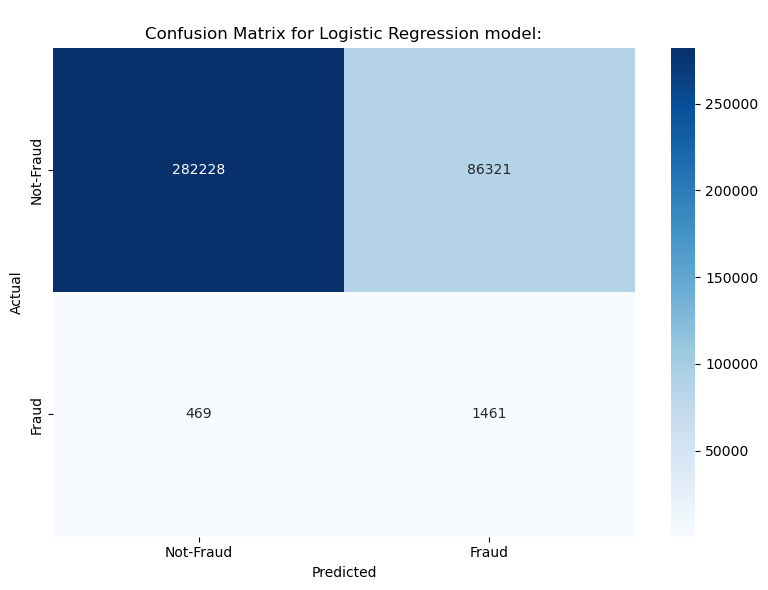


Breakdown of Confusion Matrix:

Number of True Negatives (TN) = 282228. Correctly flagged 282228 non-fraudulent transactions as not-fraud.
Number of False Positives (FP) = 86321. Incorrectly flagged 86321 non-fraudulent transactions as fraud.
Number of False Negatives (FN) = 469. Incorrectly flagged 469 fraudulent transactions as not-fraud.
Number of True Positives (TP) = 1461. Correctly flagged 1461 fraudulent transactions as fraud.

Fraud Detection Rate (Recall): 75.70%

Fraud Miss Rate: 24.30%


In [127]:
#Evaluate the Logistic Regression model
evaluate_model(Y_test, Y_pred_logistic_regression, "Logistic Regression")

Evaluating the Random Forest model: 

Classification Report for Random Forest:
              precision    recall  f1-score   support

   Not-Fraud       1.00      1.00      1.00    368549
       Fraud       0.98      0.72      0.83      1930

    accuracy                           1.00    370479
   macro avg       0.99      0.86      0.91    370479
weighted avg       1.00      1.00      1.00    370479



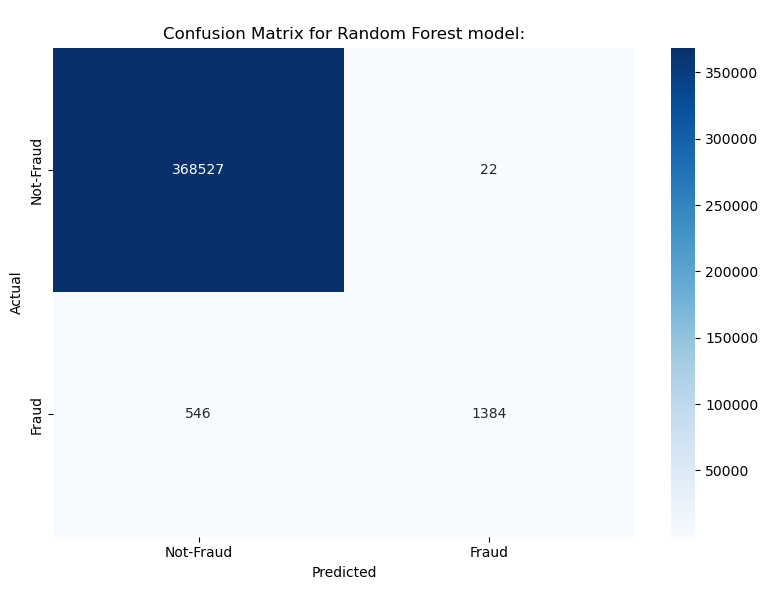


Breakdown of Confusion Matrix:

Number of True Negatives (TN) = 368527. Correctly flagged 368527 non-fraudulent transactions as not-fraud.
Number of False Positives (FP) = 22. Incorrectly flagged 22 non-fraudulent transactions as fraud.
Number of False Negatives (FN) = 546. Incorrectly flagged 546 fraudulent transactions as not-fraud.
Number of True Positives (TP) = 1384. Correctly flagged 1384 fraudulent transactions as fraud.

Fraud Detection Rate (Recall): 71.71%

Fraud Miss Rate: 28.29%


In [129]:
#Evaluate the Random Forest model
evaluate_model(Y_test, Y_pred_random_forest, "Random Forest")

Evaluating the Isolation Forest model: 

Classification Report for Isolation Forest:
              precision    recall  f1-score   support

   Not-Fraud       0.99      0.99      0.99    368549
       Fraud       0.01      0.01      0.01      1930

    accuracy                           0.99    370479
   macro avg       0.50      0.50      0.50    370479
weighted avg       0.99      0.99      0.99    370479



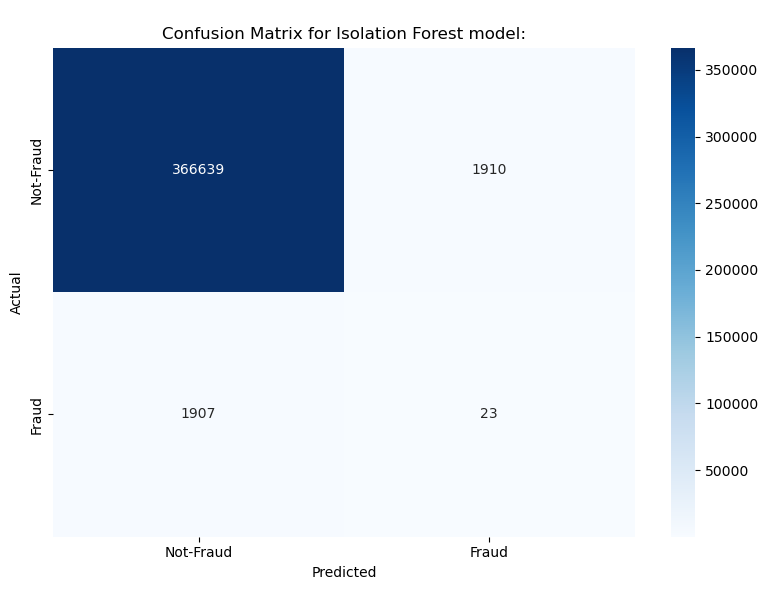


Breakdown of Confusion Matrix:

Number of True Negatives (TN) = 366639. Correctly flagged 366639 non-fraudulent transactions as not-fraud.
Number of False Positives (FP) = 1910. Incorrectly flagged 1910 non-fraudulent transactions as fraud.
Number of False Negatives (FN) = 1907. Incorrectly flagged 1907 fraudulent transactions as not-fraud.
Number of True Positives (TP) = 23. Correctly flagged 23 fraudulent transactions as fraud.

Fraud Detection Rate (Recall): 1.19%

Fraud Miss Rate: 98.81%


In [131]:
#Evaluate the Isolation Forest model
evaluate_model(Y_test, Y_pred_isolation_forest, "Isolation Forest")

In [1]:
'''
I evaluated the Logistic Regression, Random Forest, and Isolation Forest models using Precision, Recall, and F1-score. Because of the high
cost of False Negatives in credit card fraud/anomaly detection (letting fraud go undetected), I prioritized Recall (True Positive Rate) = 
1 - False Negative Rate as my primary metric to evaluate each model.

Here's a summary of my model evaluation:

Model Name                  Recall (True Positive Rate)       False Negative Rate
1. Logistic Regression                75.70%                         24.30%
2. Random Forest                      71.71%                         28.29%
3. Isolation Forest                    1.19%                         98.81%

The Logistic Regression model performed the best overall with a Recall of 75.70% and consequently, a False Negative Rate of 24.30%, which was
the lowest among all 3 models. However, the Precision for the Logistic Regression model was only 2%, as the model prioritized catching
fraud over minimizing false alarms. This means that the False Positive Rate is very high. I recommend prioritizing this model if the
business goal is to minimize fraud.

The Random Forest model is a strong alternative with a Recall of 71.71% and consequently, a False Negative Rate of 28.29%. In comparison to
the Logistic Regression model, the Random Forest model had a 98% Precision, which means that it had a very low False Positive Rate. I
recommend this model if the business goal is to minimize fraud, while prioritizing customer experience over maximum fraud detection.

The Isolation Forest model performed poorly on this dataset with a Recall of only 1.19% and consequently, a False Negative Rate of 98.81%,
which is catastrophically high. In the absence of labelled data, I recommend using a business rule-based fraud/anomaly detection system,
followed by active learning to bootstrap labelled datasets, and then transition to supervised learning models, while continuing the data
labelling process.

This stark difference in model performance between the supervised learning models and the unsupervised learning model demonstrates that 
labelled data is critical for effective credit card fraud/anomaly detection, as unsupervised learning methods alone are insufficient for
fraud/anomaly detection. When labels are available, we should prioritize supervised machine learning algorithms. An unsupervised machine
learning algorithm may be a useful supplement to supervised learning methods, such as for novel fraud pattern detection.
'''
print("Thank you for reading through to the end of my final project for STATS 507!")

Thank you for reading through to the end of my final project for STATS 507!
